In [ ]:
!pip install -q ultralytics transformers accelerate ftfy safetensors pillow matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00


In [ ]:
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

from ultralytics import SAM


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

gd_model_id = "IDEA-Research/grounding-dino-tiny"
processor = AutoProcessor.from_pretrained(gd_model_id)
gd_model = AutoModelForZeroShotObjectDetection.from_pretrained(gd_model_id).to(device)

sam = SAM("sam2.1_b.pt")

device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

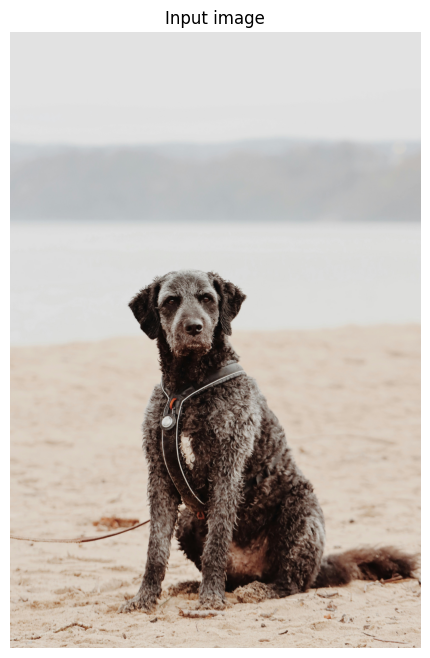

In [ ]:
def load_image(path_or_url):
    if str(path_or_url).startswith("http"):
        img = Image.open(requests.get(path_or_url, stream=True).raw).convert("RGB")
    else:
        img = Image.open(path_or_url).convert("RGB")
    return img

def show_image_pil(img, figsize=(8,8), title=None):
    plt.figure(figsize=figsize)
    plt.imshow(np.asarray(img))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

image_path = "/content/pexels-efrem-efre-2786187-20424560.jpg"
img = load_image(image_path)
show_image_pil(img, title="Input image")


In [ ]:
text_prompt = "a dog"
text_labels = [[text_prompt]]

inputs = processor(images=img, text=text_labels, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = gd_model(**inputs)

target_sizes = [img.size[::-1]]
results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    threshold=0.35,
    text_threshold=0.25,
    target_sizes=target_sizes
)

result = results[0]

def _to_pylist(x):
    if x is None:
        return []
    if isinstance(x, list):
        return x
    try:
        return x.cpu().numpy().tolist()
    except Exception:
        try:
            return list(x)
        except Exception:
            return x

boxes = _to_pylist(result.get("boxes"))
scores = _to_pylist(result.get("scores"))

if "text_labels" in result and result["text_labels"] is not None:
    labels = _to_pylist(result["text_labels"])
else:
    raw_labels = _to_pylist(result.get("labels"))
    provided_flat = [t for sub in text_labels for t in sub]
    labels = []
    for rl in raw_labels:
        if isinstance(rl, int) and rl < len(provided_flat):
            labels.append(provided_flat[rl])
        else:
            labels.append(str(rl))

print("Result keys:", list(result.keys()))
print("Found boxes:", len(boxes))
for i, (b, s, l) in enumerate(zip(boxes, scores, labels)):
    print(i, "box", [round(float(x), 2) for x in b], "score", round(float(s), 3), "label", l)


Result keys: ['scores', 'boxes', 'text_labels', 'labels']
Found boxes: 1
0 box [1235.87, 2654.85, 3606.98, 6575.78] score 0.419 label a dog


In [ ]:

if len(boxes) == 0:
    raise RuntimeError("No boxes found for the prompt. Try a different prompt or lower thresholds.")

sam_boxes = [list(map(float, b)) for b in boxes]

img_np = np.asarray(img)[:, :, ::-1]
results = sam(img_np, bboxes=sam_boxes)

masks = []
for res in results:
    if hasattr(res, "masks") and res.masks is not None:
        try:
            mask_arr = res.masks.data.cpu().numpy()
        except Exception:
            mask_arr = np.asarray(res.masks)
        masks = [mask_arr[i] for i in range(mask_arr.shape[0])]
        break

print("SAM returned masks:", len(masks))



0: 1024x1024 1 0, 500.3ms
Speed: 369.0ms preprocess, 500.3ms inference, 31.7ms postprocess per image at shape (1, 3, 1024, 1024)
SAM returned masks: 1


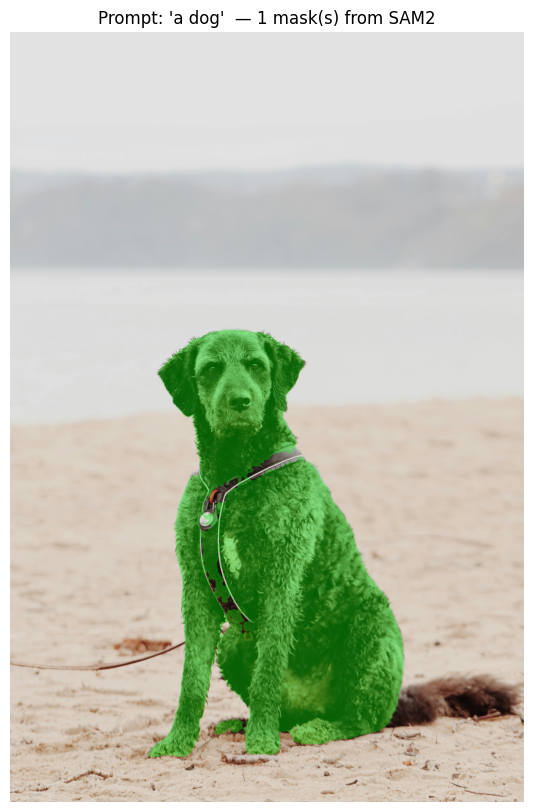

In [ ]:
def overlay_masks_on_image(image_pil, masks_list, color=(255,0,0), alpha=0.4):
    img = np.array(image_pil).astype(np.float32)
    canvas = img.copy()
    h, w = img.shape[:2]
    for i, mask in enumerate(masks_list):
        if mask.shape != (h, w):
            mask = cv2.resize(mask.astype("uint8")*255, (w, h))
            mask = (mask > 127)
        color_arr = np.array(color).reshape(1,1,3)
        canvas[mask] = canvas[mask] * (1 - alpha) + color_arr * alpha
    return canvas.astype(np.uint8)

if len(masks) == 0:
    raise RuntimeError("No masks to visualize.")

overlay = overlay_masks_on_image(img, masks, color=(0,255,0), alpha=0.35)
plt.figure(figsize=(10,10))
plt.imshow(overlay)
plt.axis('off')
plt.title(f"Prompt: '{text_prompt}'  — {len(masks)} mask(s) from SAM2")
plt.show()
